<a href="https://colab.research.google.com/github/piyushjharbade/GAIT-for-Neurodegenerative-disease/blob/main/silhoutte_heat_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this lesson we learn what parts of the image does a deep learning model pay attention to. We concolude that depending on how deep we go in the network we learn different levels of attention maps.

## Imports

We use TensorFlow with eager execution

In [4]:

!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00


In [7]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.3 MB/s eta 0:00:00


In [8]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.resnet50 import preprocess_input



## Pretrained Model

We use the resnet model without the dense layers because we are only interested in seeing 2D activations.

In [9]:
resnet_50 = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Example Image

In [ ]:
!wget https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg -O cat.jpg

--2019-09-16 11:24:03--  https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.208.102, 104.17.209.102, 2606:4700::6811:d066, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.208.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 945751 (924K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 923.58K  --.-KB/s    in 0.02s   

2019-09-16 11:24:03 (39.1 MB/s) - ‘cat.jpg’ saved [945751/945751]



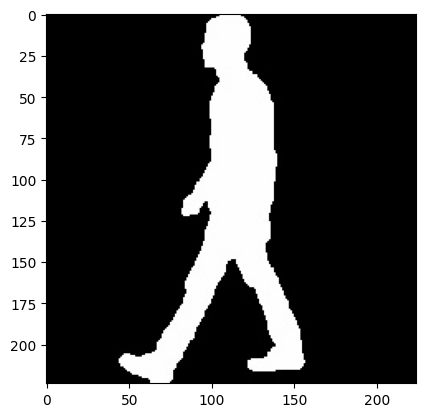

In [10]:
img = cv2.imread("/content/frame550.jpg")[:,:,::-1]
img = cv2.resize(img, (224, 224))
ax = plt.imshow(img)

## Preprocessing

In [11]:
def preprocess(img):
  # use the pre processing function of ResNet50
  img = preprocess_input(img)

  #expand the dimension
  return np.expand_dims(img, 0)

In [12]:
input_image = preprocess(img)

## Activation Maps

Given the pretrained model we want to extract the activation maps at a certain layer. We index the layers using natural numbers. The activation maps at a given index is a function of the form

$$f: \mathbb{R}^{H \times W \times 3} \to \mathbb{R}^{H' \times W' \times C}$$

In simple terms, given an input image of three channels the output is a 3-d tensor representing the activation at the given layer.

In [13]:
def get_activations_at(input_image, i):
  #index the layer
  out_layer = resnet_50.layers[i]

  #change the output of the model
  model = tf.keras.models.Model(inputs = resnet_50.inputs, outputs = out_layer.output)

  #return the activations
  return model.predict(input_image)

## Attention Maps
After getting the activations in the shape $(H', W', C)$ we want to represent what parts of the image is the activation paying attention to the most. To do that we need to convert the shape of the activations to the form $(H', W')$ or mathematically

$$g: \mathbb{R}^{H' \times W' \times C} \to \mathbb{R}^{H' \times W'} $$

We call $g$ a spatial attention map function  [ref](https://arxiv.org/pdf/1612.03928.pdf). There are many functions that we could use as described by the paper. In this demo we will use the sum of the absolute value of the activations across the channel. Formally, given an activation $A$ we define $A_i = A[:,:,i]$ which represents an index across the channel dimension. Then we can evaluate the attention map as

$$g(A) = \sum_{i=1}^C |A_i|$$



In [14]:
def postprocess_activations(activations):

  #using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(activations)
  output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image
  output = cv2.resize(output, (224, 224))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

## Generate Heatmaps

For visuals we use the functions `applyColorMap` and `addWeighted`

In [15]:
def apply_heatmap(weights, img):
  #generate heat maps
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
  return heatmap

In [16]:
def plot_heatmaps(rng):
  level_maps = None

  #given a range of indices generate the heat maps
  for i in rng:
    activations = get_activations_at(input_image, i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights, img)
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = np.concatenate([level_maps, heatmap], axis = 1)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  ax = plt.imshow(level_maps)


In [ ]:
#Ideal setting(Dont change)

#plot_heatmaps(range(164, 175))
#plot_heatmaps(range(76, 90))
#plot_heatmaps(range(3, 25))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━

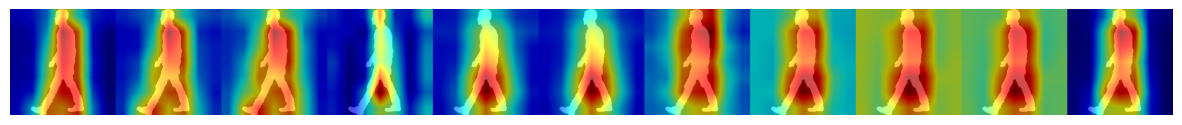

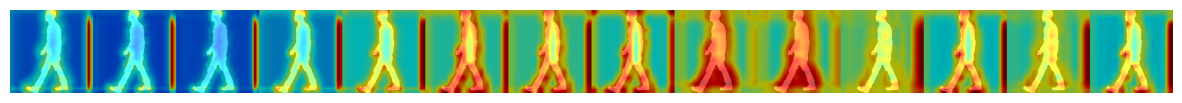

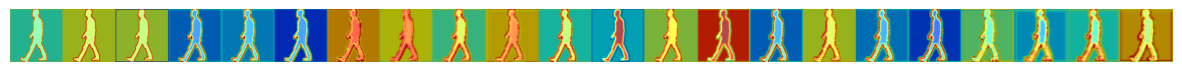

In [17]:
plot_heatmaps(range(164, 175))
plot_heatmaps(range(76, 90))
plot_heatmaps(range(3, 25))

In [18]:
import os

In [19]:
output_dir = 'heatmaps4'
os.makedirs(output_dir, exist_ok=True)

## Read more

1. [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)
2. [Paying More Attention to Attention](https://arxiv.org/abs/1612.03928)

In [24]:
def plot_heatmaps(rng):
  for i in rng:
    activations = get_activations_at(input_image, i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights, img)

    # Save the heatmap as a PNG file
    filename = os.path.join(output_dir, f'heatmap4_{i}.png')
    plt.figure()  # Create a new figure for each heatmap
    plt.imshow(heatmap)
    plt.axis('off')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to release resources

In [25]:
plot_heatmaps(range(164, 175))
plot_heatmaps(range(76, 90))
plot_heatmaps(range(3, 25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━

In [26]:
# Replace 'folder_name' with the actual folder name
!zip -r heatmaps4.zip heatmaps4
from google.colab import files
files.download('heatmaps4.zip')


updating: heatmaps4/ (stored 0%)
updating: heatmaps4/heatmap4_89.png (deflated 15%)
updating: heatmaps4/heatmap4_87.png (deflated 14%)
updating: heatmaps4/heatmap4_157.png (deflated 14%)
updating: heatmaps4/heatmap4_169.png (deflated 15%)
updating: heatmaps4/heatmap4_165.png (deflated 16%)
updating: heatmaps4/heatmap4_160.png (deflated 17%)
updating: heatmaps4/heatmap4_23.png (deflated 15%)
updating: heatmaps4/heatmap4_163.png (deflated 17%)
updating: heatmaps4/heatmap4_168.png (deflated 15%)
updating: heatmaps4/heatmap4_17.png (deflated 15%)
updating: heatmaps4/heatmap4_86.png (deflated 15%)
updating: heatmaps4/heatmap4_14.png (deflated 16%)
updating: heatmaps4/heatmap4_10.png (deflated 18%)
updating: heatmaps4/heatmap4_156.png (deflated 16%)
updating: heatmaps4/heatmap4_155.png (deflated 16%)
updating: heatmaps4/heatmap4_158.png (deflated 16%)
updating: heatmaps4/heatmap4_5.png (deflated 20%)
updating: heatmaps4/heatmap4_21.png (deflated 14%)
updating: heatmaps4/heatmap4_88.png (defl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>